In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
import torch
import cv2
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import os


In [3]:
NUM_FEATURES = 20
ARE_HOOKS_ATTACHED = False
resnet = models.resnet50(pretrained=True).cuda()
densenet = models.densenet161(pretrained=True).cuda()
TRAIN = '/content/drive/My Drive/Datasets/Jewellery/data/'
OUTPUT = []
reshapers = {
    'resnet':2048,
    'densenet':108192
}

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 134344430.84it/s]
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:09<00:00, 12577041.27it/s]


## Creating and attaching a hook to the last layer

In [ ]:
def hook(self, input, output):
    global OUTPUT
    OUTPUT.append(output)
    

def attach_hooks():
    global ARE_HOOKS_ATTACHED, resnet, densenet
    if ARE_HOOKS_ATTACHED:
        print('Hooks already attached')
    else:
        resnet.avgpool.register_forward_hook(hook) 
        densenet.features.norm5.register_forward_hook(hook)
        ARE_HOOKS_ATTACHED = True
    
    
def preprocess(img_path):
    img = cv2.imread(img_path)
    resized = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    inp = torch.from_numpy(resized)
    inp = inp.view(1, 3, 224, 224).to(device='cuda', dtype=torch.float)
    return inp
    
    
def forward(inp):
    global OUTPUT, resnet, densenet
    OUTPUT = []
    resnet(inp)
    densenet(inp)

attach_hooks()

In [5]:
!wget https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl

--2019-06-27 10:09:58--  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5a15c9cc393ec612061f033a/5ac54beae586bb11ec0ace46?response-content-disposition=attachment%3B%20filename%3D%22faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20190627T100958Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=AgoJb3JpZ2luX2VjEPX%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIQDKUzzQ9abTS8a6yjecemeicezdsIx1AnjpR%2Fwoqf%2BiDgIgNbVcqJ00tvy2ma2%2BIPterJq1wbDwkpqJ9egAfBlsuYgq2gMIPRAAGgw0NTU4NjQwOTgzN

## Calculating the descriptors from resnet and densenet, appending them and indexing using faiss

In [6]:
import faiss


index = faiss.IndexFlatL2(110240)
image_paths = os.listdir(TRAIN)


with torch.no_grad():
    for i in range(0, len(image_paths)):
        if i % 200 == 0:
            print(f'{i} images done')
        
        inp = preprocess(TRAIN + image_paths[i])
        forward(inp)
        OUTPUT[0] = OUTPUT[0].reshape(reshapers['resnet'])
        OUTPUT[0] = OUTPUT[0].cpu().numpy()
        OUTPUT[1] = OUTPUT[1].reshape(reshapers['densenet'])
        OUTPUT[1] = OUTPUT[1].cpu().numpy()
        op = np.concatenate((OUTPUT[0], OUTPUT[1]))
#         print(op.shape)
        index.add(op.reshape(1, op.shape[0]))
            
        torch.cuda.empty_cache()

0 images done
200 images done
400 images done
600 images done
800 images done
1000 images done
1200 images done


In [ ]:
import pickle 


# Its important to use binary mode 
dbfile = open('descriptors.pkl', 'ab') 

# source, destination 
pickle.dump(descriptors, dbfile)                      
dbfile.close() 


# Its important to use binary mode 
dbfile_paths = open('image_paths.pkl', 'ab') 

# source, destination 
pickle.dump(image_paths, dbfile_paths)                      
dbfile.close()

## Example input image (BGR)

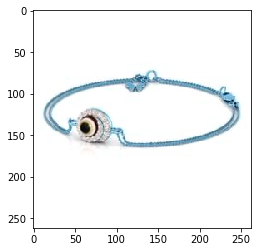

In [15]:
img = cv2.imread(TRAIN + 'bracelet_048.jpg')
plt.imshow(img)

## Outputs calculated by directly returning similar descriptors using faiss

bracelet_048.jpg


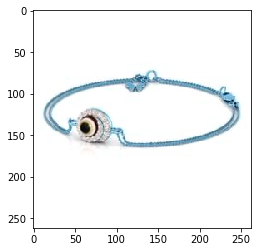

bracelet_076.jpg


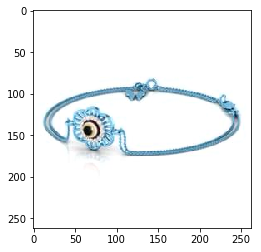

bracelet_072.jpg


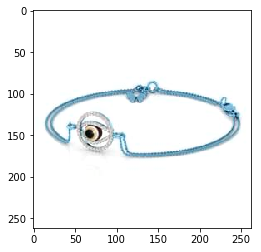

bracelet_264.jpg


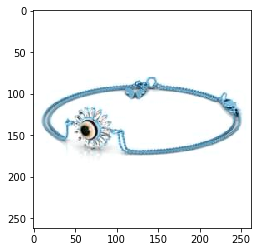

bracelet_077.jpg


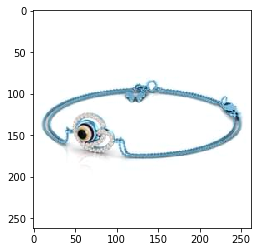

bracelet_058.jpg


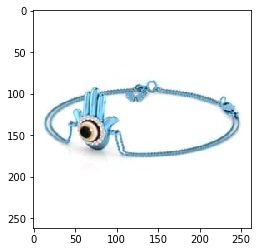

bracelet_256.jpg


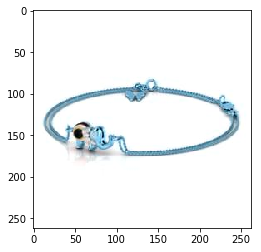

bracelet_026.jpg


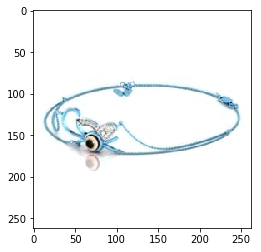

bracelet_060.jpg


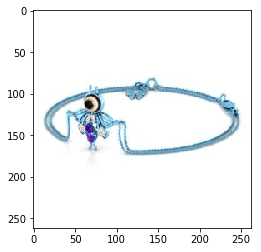

bracelet_220.jpg


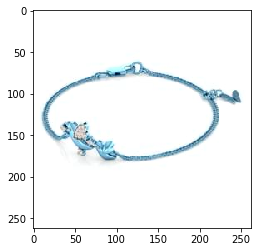

In [10]:
with torch.no_grad():
    query_image = TRAIN + 'bracelet_048.jpg'
    forward(preprocess(query_image))
    OUTPUT[0] = OUTPUT[0].reshape(reshapers['resnet'])
    OUTPUT[0] = OUTPUT[0].cpu().numpy()
    OUTPUT[1] = OUTPUT[1].reshape(reshapers['densenet'])
    OUTPUT[1] = OUTPUT[1].cpu().numpy()
    op = np.concatenate((OUTPUT[0], OUTPUT[1]))
    distance, indices = index.search(op.reshape(1, op.shape[0]), 10)

    for i in indices[0]:
        print(image_paths[i])
        img = cv2.imread(TRAIN + image_paths[i])
        plt.imshow(img)
        plt.show()